<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Redes Recurrentes y Autoencoders  </H3>
<hr style="height:2px;border:none"/>

**Integrantes**  
* Jorge Núñez C. 201211508-6
* Tomás Ochoa A. 201423007-9


## 1. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.<br>
<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


Se procede a descargar los datos de la página de Kaggle, para realizar la descarga es necesario seguir el proceso de autorización de google, montar el drive y utilizar la llave de Kaggle (necesario registrarse) para poder descargar directamente desde su página web el contenido requerido.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cd drive && cd '/content/drive/My Drive/' && cp kaggle.json ~/.kaggle/
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
 88% 24.0M/27.2M [00:00<00:00, 14.5MB/s]
100% 27.2M/27.2M [00:00<00:00, 42.9MB/s]
drive  entity-annotated-corpus.zip  sample_data


Se descomprime la descarga

In [2]:
!unzip entity-annotated-corpus.zip

Archive:  entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


Luego es posible leer el archivo "ner.csv" mediante pandas

In [3]:
import numpy as np
import pandas as pd
df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


*Comentario: El procedimiento ocupado para realizar la lectura del archivo ner.csv resulta muy veloz ante la variante de ocupar files.download() que se ocupó en un inició. Es justo comentar que el procedimiento ocupado acá ha sido compartido con nosotros por el compañero Gabriel Rudloff.*

> **a)** En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a esto.

Se crea dataset extrayendo las columnas de interés del archivo descargado. Adicionalmente se visualizan los primeros diez datos de éste.

In [4]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
dataset[0:20]

,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O
5,through,through,IN,O,O
6,london,London,NNP,B-geo,O
7,to,to,TO,O,B-geo
8,protest,protest,VB,O,O
9,the,the,DT,O,O


*Comentario: Vale explicar por qué la columna 'lemma' posee las mismas palabras, respectivamente, que la columna 'words' con leves modificaciones. Lema ('lemma' en inglés), es la forma canónica de una familia de palabras, por ejemplo, corrió, corriendo, correrá y corrirría tienen como lema la palabra correr. El utilizar los lemas de las palabras para entrenar una red neuronal ha de ser de gran ayuda, dado que se mantiene el significado de la palabra original y se acorta el diccionario con que se alimenta a la red, si bien a la vez esto tiene la implicancia de omitir el tiempo verbal y pluralidad de la palabra original ésto no es tan drástico, pues la palabra se encuentra sumergida en un contexto. <br><br>  El data set cuenta con la cualidad POS de los datos, ésta entrega información de la ubicación de la palabra dentro de una sentencia haciendo uso de la técnica 'chunking', consistente en segmentar y multi-etiquetar secuencias de varias palabras siguiendo distintos niveles de segmentación, dando lugar a que grupos de segmentos formen parte de un segmento mayor donde cada cual posee una etiqueta,  luego de realizar la segmentación cada palabra contará con una etiqueta que representará su posición en el texto, en este caso se utilizó la notación estandar IOB. <br><br> Por último las columnas tag y pre-iob entregan calificaciones de la palabra respectiva y previa respectivamente, visualizando el segmento de 25 datos iniciales se ve que se poseen etiquetas B-geo para ubicaciones geográficas, B-gpe para nacionalidad y Start1 para separar sentencias, siendo posible encontrar más asignaciones a lo largo del dataset.*

> Se procede a crear una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá las etiquetas (tags), esto es un arreglo de arreglos de lemmas y un arreglo de arreglos de tags respectivamente. ¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?

Se realiza la separación de sentencias al texto entregado guardando el lema y etiqueta de cada dato dentro de ésta

In [0]:
dataX,dataY = [],[]
lemmas,labels = set(), set()  #uniques
sentence=[]
labels_sentence=[]
c=0
for fila in dataset.values:
    if fila[-1]=="__START1__" and c!=0: 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence= []
        labels_sentence = []
    c+=1
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[3]) #TAG
dataX = np.asarray(dataX) #data to  array
dataY = np.asarray(dataY)

Se comprueba la separación de sentencias visualizando las etiquetas y tags de la primera sentencia.

In [91]:
print('Lemas:\n\n',dataX[20],'\nEtiquetas:\n\n',dataY[20],'\n\nLema y etiqueta dato número 21:',dataX[20][21],', ',dataY[20][21])

Lemas:

 ['local' 'news' 'report' 'said' 'at' 'least' 'five' 'mortar' 'shell' 'hit'
 'the' 'palac' 'compound' 'and' 'other' 'mortar' 'were' 'fire' 'elsewher'
 'in' 'mogadishu' 'wednesday' '.'] 
Etiquetas:

 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'B-geo' 'B-tim' 'O'] 

Lema y etiqueta dato número 21: wednesday ,  B-tim


Cada sentencia posee un largo distinto de datos, a continuación se ve la coherencia de tamaño de cantidad de lemas y tags para cada sentencia y diferencias de largo entre ellas para los primeros 15 datos.

In [0]:
for i in range(15):
  print('Dimensión',i,'° Sentencia:',dataX[i].shape,dataY[i].shape)

Dimensión 0 ° Sentencia: (24,) (24,)
Dimensión 1 ° Sentencia: (30,) (30,)
Dimensión 2 ° Sentencia: (14,) (14,)
Dimensión 3 ° Sentencia: (15,) (15,)
Dimensión 4 ° Sentencia: (25,) (25,)
Dimensión 5 ° Sentencia: (24,) (24,)
Dimensión 6 ° Sentencia: (21,) (21,)
Dimensión 7 ° Sentencia: (28,) (28,)
Dimensión 8 ° Sentencia: (15,) (15,)
Dimensión 9 ° Sentencia: (25,) (25,)
Dimensión 10 ° Sentencia: (12,) (12,)
Dimensión 11 ° Sentencia: (34,) (34,)
Dimensión 12 ° Sentencia: (29,) (29,)
Dimensión 13 ° Sentencia: (26,) (26,)
Dimensión 14 ° Sentencia: (40,) (40,)


Se poseen 48081 sentencias para entrenar a la red

In [0]:
print(dataX.shape,dataY.shape)

(48081,) (48081,)


A la vez se poseen en total 20243 lemas y 17 etiquetas

In [0]:
len(lemmas),len(labels)

(20243, 17)

> **b)** Se estudia la distribución del largo de los textos a procesar, junto con la frecuencia con la que aparecen las palabras en todo el dataset.

Se procede a graficar el tamañano en 'palabras' (de vez en cuando se usan carácteres en lugar de palabras, como se vio en el ítem previo) de cada sentencia dentro de dataX

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,5]
largo=[]
for i in range(dataX.shape[0]):
  largo.append(dataX[i].shape[0])  
lnp=np.asarray(largo)

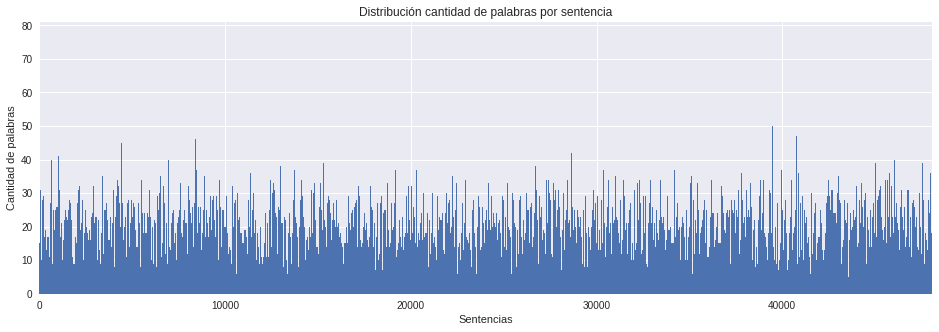

In [0]:
plt.bar(np.arange(dataX.shape[0]),lnp, align='edge', alpha=1,width=-1)
plt.xlim([0,dataX.shape[0]])
plt.ylim([0,np.amax(lnp)])
plt.title('Distribución cantidad de palabras por sentencia')
plt.ylabel('Cantidad de palabras')
plt.xlabel('Sentencias')
plt.show()

Dada la bastedad de sentencias no se alcanza a distinguir de forma correcta el máximo, es por esto que se aplica un zoom al gráfico con el fin de distinguirlo a continuación

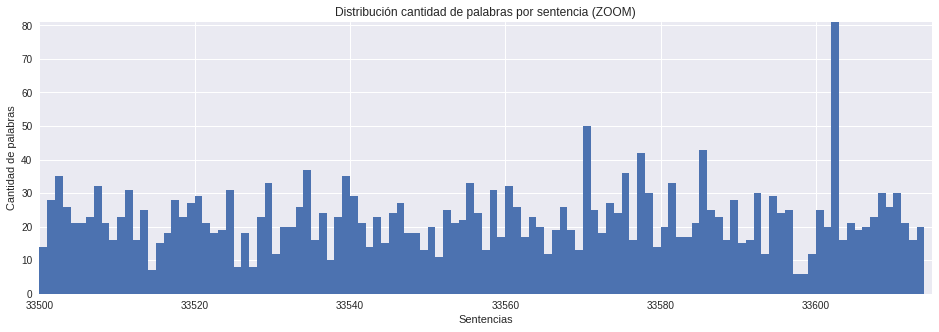

In [0]:
plt.bar(np.arange(dataX.shape[0])[33500:33615],lnp[33500:33615], align='edge', alpha=1,width=-1)
plt.ylim([0,np.amax(lnp)])
plt.xlim([33500,33615])
plt.title('Distribución cantidad de palabras por sentencia (ZOOM)')
plt.ylabel('Cantidad de palabras')
plt.xlabel('Sentencias')
plt.show()

Se distingue amplia variación de largo entre sentencias, a continuación se entregan ciertos datos estadísticos de esta distribución.

In [0]:
print('Desviación estandar:',np.std(lnp),'\nLargo mínimo:',np.amin(lnp),'\nLargo máximo:',np.amax(lnp),'\nLargo promedio:',np.mean(lnp))

Desviación estandar: 7.951486671039672 
Largo mínimo: 1 
Largo máximo: 81 
Largo promedio: 21.854495538778313


A  continuación se procede a visualizar la frecuencia con que se repiten lemas a lo largo de todo el data set, la cual se compara con la ley de Zipf, la cual plantea que la frecuencia con que aparecen las palabras en una determinada lengua sigue una distribución $P_n\sim M/n^a$, donde $P_n$ representa la frecuencia de la n-ésima palabra más frecuente, $M$ la mayor frecuencia encontrada para una palabra dentro de la lengua y $a$ es un número real positivo ajustable.

Para esto se busca la frecuencia con que aparece cada palabra, ordenando los lemas en el eje de las absicas según la cantidad de veces que aparece en todo el data set, luego se superpone sobre ésta la distribución propuesta por Zipf con un valor de $a$ de 0.85 para un mejor ajuste. 

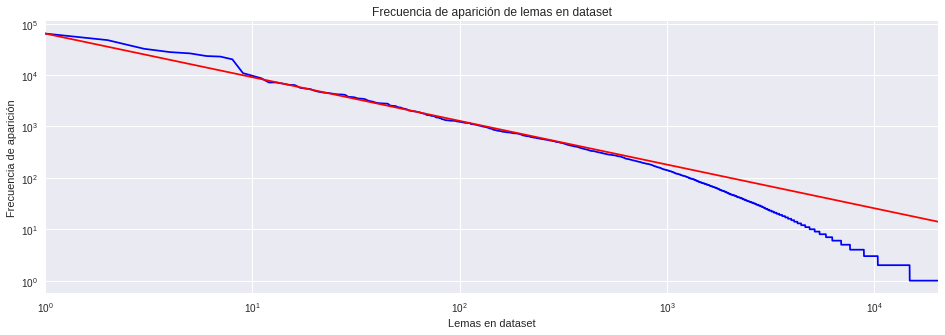

In [0]:
import collections
cnt=collections.Counter()
for fila in dataset.values:
  cnt[fila[0]]+=1
asd=[]
prim=cnt.most_common(1)[0][1]
for k in range(len(cnt)):
  k+=1
  a=0.85
  asd.append(prim/(k**a))
plt.yscale('log')
plt.xscale('log')
plt.plot(np.arange(1,len(cnt)+1),np.asarray(np.asarray(cnt.most_common(len(cnt)))[:,1],dtype=float),'b')
plt.plot(np.arange(1,len(cnt)+1),asd,'r')
plt.xlim([1,len(cnt)+1])
plt.title('Frecuencia de aparición de lemas en dataset')
plt.xlabel('Lemas en dataset')
plt.ylabel('Frecuencia de aparición')
plt.show()

*Comentario: Se logra una distribución que sigue de buena forma la ley de Kipf para los datos intermedios. Es posible ajustar tan solamente el valor de $a$ por lo cual se posee cierta flexibilidad, se pueden utilizar distintos valores de $a$ para obtener mejores ajustes en diferentes zonas de los datos entregrados.*

> **c)** Se transforman los datos de entrada y salida de modo que puedan ser entregados apropiadamente a la red, será necesario crear una función que codifique cada posible lemma a un número y cada posible tag a otro número.

El dataset cuenta con un largo máximo de 62 palabras en una sentencia (ítem previo), lo cual hace necesario rellenar las demás sentencias de modo que se cuente con el mismo largo. Lo cual se hace de forma manual a continuación

Ahora se procede a transformar palabras y etiquetas a números, de modo de poder alimentar la red neuronal de forma adecuada. Se añade al conjunto de lemmas y labbels los carácteres ' !!' los cuales poseen una enumeración baja dentro del diccionario ANSI.

In [0]:
lemmas.add(' !!')
labels.add(' !!')
lemmas=sorted(lemmas)
labels=sorted(labels)
datax=np.copy(dataX)
datay=np.copy(dataY)
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in datax]
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in datay]
n_lemmas = len(lemmas)
n_labels = len(labels)

> **d)** Ahora se realiza el proceso de padding sobre la data generada en el ítem anterior utilizando el preprocesador de Keras.

In [0]:
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX,maxlen=np.amax(lnp),padding='post',value=lemma2idx[" !!"]) 
y = sequence.pad_sequences(dataY,maxlen=np.amax(lnp),padding='post',value=lab2idx[" !!"])

Using TensorFlow backend.


Obteniéndose un resultado equivalente en ambos casos

*Comentario: ¿Por qué se decidió realizar el padding al final de cada sentencia y no al inicio? Dada la forma en que se propaga la información en la red neuronal recurrete, donde para generar una salida dentro de la red se toman en consideración valores previos de la alimentación, siendo posible que al incluir el padding al inicio de la sentencia la red arrastre información no relevante (ruidosa) a lo largo de toda su salida, en cambio, al incluir al final el padding esta información no relevante será tomada en consideración para predicciones futuras donde ya se ha terminado la sentencia, no entorpeciendo la predicción de manera tan severa.*

Se procede a visualizar tanto la enumeración de lemmas como la etiqueta brindada a cada uno para uno de los datos generados, luego de aplicar el padding

In [50]:
X[0]

array([18208, 13359,  5910,  8805, 11647, 18247, 11237, 18333, 14716,
       18129, 19551,  9445,  9762,  2523,  5890, 18129, 19814, 13359,
        4087, 18569,  7841, 18127,  5407,    17,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [52]:
y[0]

array([17, 17, 17, 17, 17, 17,  3, 17, 17, 17, 17, 17,  3, 17, 17, 17, 17,
       17,  4, 17, 17, 17, 17, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

*Comentario: Resulta exitosa la implementación del padding*

> **e)** Para poder entregar una clasificación sobre los distintos tags es necesario tranformarlos a one hot vectors, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles tags. A la vez se torna necesario dividir el dataset en conjuntos de entrenamiento y pruebas.

In [0]:
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

Luego es posible visualizar la dimensionalidad de los conjuntos de entrenamiento y pruebas

In [0]:
print('Dimensión de entrada dataset : ',X.shape,'\nDimensión de salida dataset : ',y.shape,)
print('Dimensión de entrada dataset de entrenamiento : ',X_train.shape,'\nDimensión de salida dataset de entrenamiento: ',y_train.shape,)
print('Dimensión de entrada dataset de pruebas : ',X_test.shape,'\nDimensión de salida dataset de pruebas : ',y_test.shape,)

Dimensión de entrada dataset :  (48081, 81) 
Dimensión de salida dataset :  (48081, 81, 18)
Dimensión de entrada dataset de entrenamiento :  (33656, 81) 
Dimensión de salida dataset de entrenamiento:  (33656, 81, 18)
Dimensión de entrada dataset de pruebas :  (14425, 81) 
Dimensión de salida dataset de pruebas :  (14425, 81, 18)


*Comentario: Se ha añadido efectiva la etiqueta al lema ' !!' utilizada como padding, a la vez se distingue que se cuenta con 48081 sentencias de largo 81, las cuales han sido etiquetadas mediante un one hot vector de largo 18.*

> **f)** Se define una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, se entrena y evalúa su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*.

Se plantea el siguiente modelo de red neuronal

In [0]:
from keras.models import Sequential
from keras.callbacks import History
from keras.layers import LSTM, Embedding, Dense, Dropout
embedding_vector = 64
model = Sequential()
hist=History()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, epochs=5, batch_size=128,callbacks=[hist])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 81, 64)            1295616   
_________________________________________________________________
lstm_4 (LSTM)                (None, 81, 100)           66000     
_________________________________________________________________
dense_17 (Dense)             (None, 81, 18)            1818      
Total params: 1,363,434
Trainable params: 1,363,434
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 71s 2ms/step - loss: 0.4607 - val_loss: 0.1829
Epoch 2/5
33656/33656 [==============================] - 68s 2ms/step - loss: 0.1328 - val_loss: 0.1044
Epoch 3/5
33656/33656 [==============================] - 68s 2ms/step - loss: 0.0838 - val_loss: 0.0682
Epoch 4/5
33656/33656 [===========

*Comentario: El embedding ayuda a convertir el espacio de representación original (lemas enumerados en cada sentencia) desde el espacio discreto a una salida de dimensión (81,64), manteniéndose la cantidad de lemas por sentencia pero ahora representados en un vector de largo 64 en lugar de un vector de largo 20243. Luego la representación de los lemas obtenidos por el embedding son entradas a las compuertas LSTM, mientras su salida es entregada a la capa de salida que contiene la cantidad de etiquetas posibles. <br><br>
Es de saber que el uso de una red recurrente ayuda a disminuir el número de parámetros entrenables, dado que los pesos entre secuencias es compartido, sin embargo el utilizar un embedding entrenable aumenta notoriamente esta cantidad de parámetros.*

Se procede a visualizar el proceso de entrenamiento

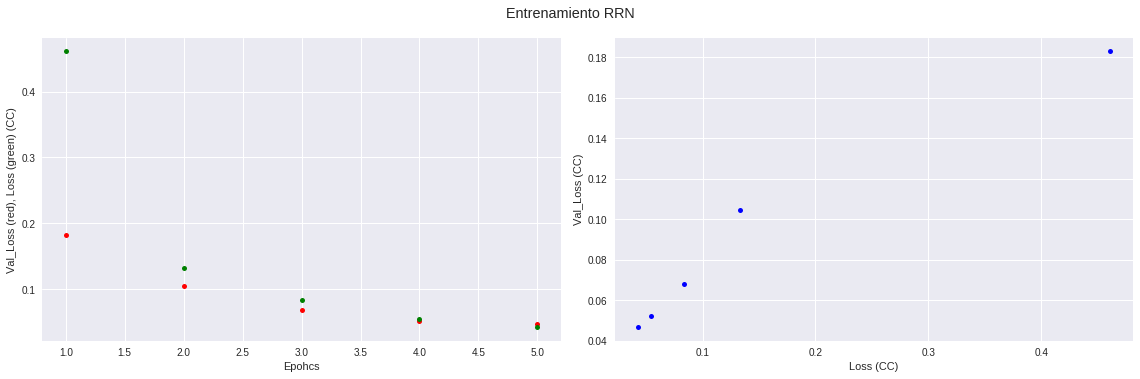

In [0]:
plt.rcParams["figure.figsize"] = [16,5]
a=np.linspace(1,5,5)
plt.subplot(1,2,1)
plt.suptitle('Entrenamiento RRN',y=1.05)
plt.plot(a,hist.history['val_loss'],'r.',markersize=10)
plt.plot(a,hist.history['loss'],'g.',markersize=10)
plt.xlabel('Epohcs')
plt.ylabel('Val_Loss (red), Loss (green) (CC)')
plt.subplot(1,2,2)
plt.plot(hist.history['loss'],hist.history['val_loss'],'b.',markersize=10)
plt.xlabel('Loss (CC)')
plt.ylabel('Val_Loss (CC)')
plt.tight_layout()
plt.show()

*Comentario:Se logra un entrenamiento exitoso, donde en el último epoch se logró revertir la situación de unknown fitting (error de validación menor que error de entrenamiento), el cual indica en los primeros 4 epochs que a la red le faltaba aún entrenamiento.*

Se procede a evaluar el modelo utilizando una métrica f1_score, la cual es adecuada para el desbalance presente entre las clases, ésta entregará un resultado igual a uno cuando se tenga una predicción perfecta como se ve a continuación.

In [0]:
from sklearn.metrics import f1_score
f1_score(np.identity(5),np.identity(5),average='micro')

1.0

Se procede a visualizar la predicción del modelo sobre el conjunto de test visualizando las etiquetas como el valor entero que se les asignó previamente. Siendo posible visualizar una predicción totalmente exitosa de la primera sentencia.

In [0]:
a=model.predict(X_test)
print('Predicción y salida del conjunto de test primera sentencia:\n')
print('Predicción:\n',(np.argmax(a,axis=2))[0],'\n\n','Salida conjunto de test:\n',(np.argmax(y_test,axis=2)[0]))

Predicción y salida del conjunto de test primera sentencia:

Predicción:
 [17 17 17  4 17 17 17 17 17 17 17 17 17  3 11 17 17 17 17 17 17 17 17 17
 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0] 

 Salida conjunto de test:
 [17 17 17  4 17 17 17 17 17 17 17 17 17  3 11 17 17 17 17 17 17 17 17 17
 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


Por lo cual el indicador utilizado debiese entrega un valor unitario a continuación

In [0]:
f1_score((np.argmax(a,axis=2))[0],(np.argmax(y_test,axis=2)[0]),average='micro')

1.0

Se procede a reordenar tanto el conjunto de predicciones y de test (salida) para cada sentencia con el fin de introducir el resultado en la métrica utilizada, obteniéndose el siguiente resultado

In [0]:
f1_score(np.argmax(a,axis=2).reshape(14425*81),np.argmax(y_test,axis=2).reshape(14425*81),average='micro')

0.9868429723773455

*Comentario: Se obtiene un muy buen resultado.*

> **g)** Se procede a variar la dimensionalidad del embedding inicial y determinar si aumenta o disminuye el error de clasificación.

Se entrenan 5 redes recurrentes con distintos tamaños de embedding (16,32,64,96,128). A la vez se aumenta el número de epochs a 10, dado que durante la experimentación en este item fue posible observar unknown fitting, por lo cual a través del aumento de epochs se buscará mejorar el comportamiento y estimar en qué epoch se revierte la situación.

In [0]:
k1l=[]
k1v=[]
scores=[]
for j in [16,32,64,96,128]:
  embedding_vector = j
  model = Sequential()
  hist=History()
  model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
  model.add(LSTM(units=100,return_sequences=True))
  model.add(Dense(n_labels, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, epochs=10, batch_size=128,callbacks=[hist])
  k1l.append(hist.history['loss'])
  k1v.append(hist.history['val_loss'])
  a=model.predict(X_test)
  b=f1_score(np.argmax(a,axis=2).reshape(14425*81),np.argmax(y_test,axis=2).reshape(14425*81),average='micro')
  scores.append(b)

Train on 33656 samples, validate on 14425 samples
Epoch 1/10
33656/33656 [==============================] - 79s 2ms/step - loss: 0.5519 - val_loss: 0.2405
Epoch 2/10
33656/33656 [==============================] - 73s 2ms/step - loss: 0.2087 - val_loss: 0.1668
Epoch 3/10
33656/33656 [==============================] - 74s 2ms/step - loss: 0.1281 - val_loss: 0.1058
Epoch 4/10
33656/33656 [==============================] - 73s 2ms/step - loss: 0.0916 - val_loss: 0.0824
Epoch 5/10
33656/33656 [==============================] - 73s 2ms/step - loss: 0.0696 - val_loss: 0.0646
Epoch 6/10
33656/33656 [==============================] - 73s 2ms/step - loss: 0.0547 - val_loss: 0.0548
Epoch 7/10
33656/33656 [==============================] - 73s 2ms/step - loss: 0.0464 - val_loss: 0.0496
Epoch 8/10
33656/33656 [==============================] - 73s 2ms/step - loss: 0.0414 - val_loss: 0.0466
Epoch 9/10
33656/33656 [==============================] - 73s 2ms/step - loss: 0.0381 - val_loss: 0.0445
Epoch

*Comentario: Se aprecia que la velocidad de entrenamiento aumenta a medida que aumenta en el tamaño del embedding, lo cual está directamente relacionado con la variación del número de parámetros entrenables que provoca su modificación*

Se proceden a graficar los resultados obtenidos

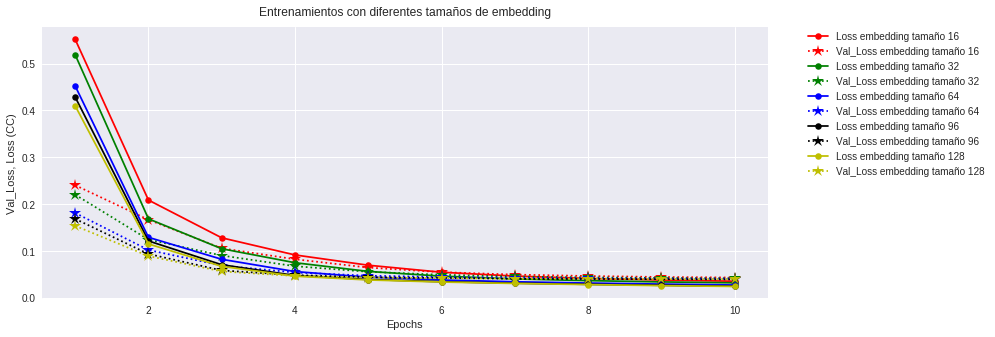

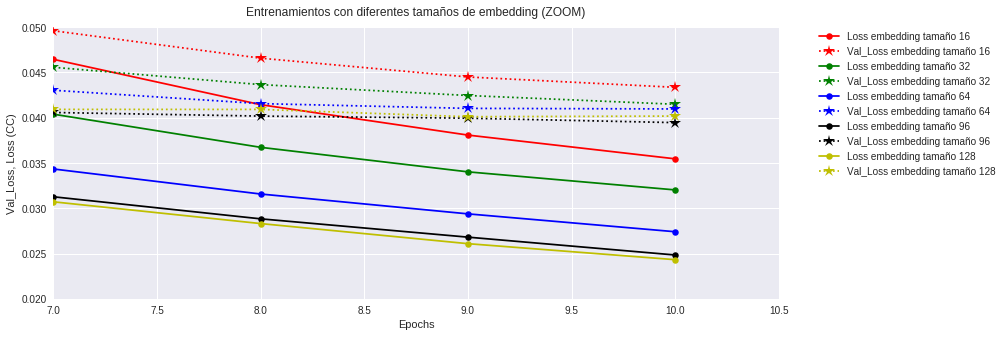

In [0]:
a=np.linspace(1,10,10)
plt.rcParams["figure.figsize"] = [13,5]
plt.title('Entrenamientos con diferentes tamaños de embedding',y=1.02)
nloss=['Loss embedding tamaño 16','Loss embedding tamaño 32','Loss embedding tamaño 64','Loss embedding tamaño 96','Loss embedding tamaño 128']
nvalloss=['Val_Loss embedding tamaño 16','Val_Loss embedding tamaño 32','Val_Loss embedding tamaño 64','Val_Loss embedding tamaño 96','Val_Loss embedding tamaño 128']
colp=['r*:','g*:','b*:','k*:','y*:']
cols=['r.-','g.-','b.-','k.-','y.-']
for i in range(5):
  plt.plot(a,k1l[i],cols[i],label=nloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,k1v[i],colp[i],label=nvalloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

plt.title('Entrenamientos con diferentes tamaños de embedding (ZOOM)',y=1.02)
for i in range(5):
  plt.plot(a,k1l[i],cols[i],label=nloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,k1v[i],colp[i],label=nvalloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([7,10.5])
plt.ylim([0.02,0.05])
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()


*Comentario: Se ve que a medida que aumenta el tamaño del embedding se obtiene un mejor comportamiento, a menos que este se aumente demasiado, como es el caso de un embedding de tamaño 128, el cual si bien obtiene un menor loss en el conjunto de entrenamiento obtiene un error de validación mayor que su predecesor (embedding tamaño 96), siendo contraproducente aumentar mucho el tamaño en embedding, tanto en tiempo de entrenamiento como resultado.<br>

Adicionalmente es posible ver que en el epoch número 7 no se presenta el fenómeno de unknown fitting para ninguna de las cinco redes, a la vez se ve que para embeddings de menor tamaño luego de este epoch sigue mejorando el error de validación, mientras para embedding de mayor tamaño se ve que se estanca éste desde el epoch número 7 hasta el 10 aproximadamente.*

En tanto los scores obtenidos son los siguientes.

In [0]:
for x in [[0,16],[1,32],[2,64],[3,96],[4,128]]:
  print('Desempeño de la red embedding tamaño',str(x[1]),': ',scores[x[0]])

Desempeño de la red embedding tamaño 16 :  0.9875576096026702
Desempeño de la red embedding tamaño 32 :  0.9878186447568308
Desempeño de la red embedding tamaño 64 :  0.9883954896548773
Desempeño de la red embedding tamaño 96 :  0.988629137514175
Desempeño de la red embedding tamaño 128 :  0.9885743629244496


*Comentario: Se obtenie un puntaje en concordancia con la jerarquía de calidad establecida por el error de validación.*

> **h)** Se utiliza Dropout para entrenar la LSTM.

Se entrenan 4 redes recurrentes, sin dropout, con dropout en la salida de la capa LSTM, con dropout recurrente y con una combinación de los dos dropouts utilizados. Se reduce la cantidad de epochs, en relación con el item anterior dado el tiempo de entrenamiento requerido.

In [0]:
k2l=[]
k2v=[]
scores2=[]
embedding_vector = 64
model = Sequential()
hist=History()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, epochs=7, batch_size=128,callbacks=[hist])
k2l.append(hist.history['loss'])
k2v.append(hist.history['val_loss'])
a=model.predict(X_test)
b=f1_score(np.argmax(a,axis=2).reshape(14425*81),np.argmax(y_test,axis=2).reshape(14425*81),average='micro')
scores2.append(b)
#Normal dropout
embedding_vector = 64
model = Sequential()
hist=History()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, epochs=7, batch_size=128,callbacks=[hist])
k2l.append(hist.history['loss'])
k2v.append(hist.history['val_loss'])
a=model.predict(X_test)
b=f1_score(np.argmax(a,axis=2).reshape(14425*81),np.argmax(y_test,axis=2).reshape(14425*81),average='micro')
scores2.append(b)
#Recurrent dropout
embedding_vector = 64
model = Sequential()
hist=History()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
model.add(LSTM(units=100,return_sequences=True,recurrent_dropout=0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, epochs=7, batch_size=128,callbacks=[hist])
k2l.append(hist.history['loss'])
k2v.append(hist.history['val_loss'])
a=model.predict(X_test)
b=f1_score(np.argmax(a,axis=2).reshape(14425*81),np.argmax(y_test,axis=2).reshape(14425*81),average='micro')
scores2.append(b)
#Combination dropout
embedding_vector = 64
model = Sequential()
hist=History()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
model.add(LSTM(units=100,return_sequences=True,recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, epochs=7, batch_size=128,callbacks=[hist])
k2l.append(hist.history['loss'])
k2v.append(hist.history['val_loss'])
a=model.predict(X_test)
b=f1_score(np.argmax(a,axis=2).reshape(14425*81),np.argmax(y_test,axis=2).reshape(14425*81),average='micro')
scores2.append(b)

Train on 33656 samples, validate on 14425 samples
Epoch 1/7
33656/33656 [==============================] - 98s 3ms/step - loss: 0.4683 - val_loss: 0.1950
Epoch 2/7
33656/33656 [==============================] - 92s 3ms/step - loss: 0.1375 - val_loss: 0.1049
Epoch 3/7
33656/33656 [==============================] - 92s 3ms/step - loss: 0.0846 - val_loss: 0.0699
Epoch 4/7
33656/33656 [==============================] - 92s 3ms/step - loss: 0.0566 - val_loss: 0.0535
Epoch 5/7
33656/33656 [==============================] - 91s 3ms/step - loss: 0.0441 - val_loss: 0.0469
Epoch 6/7
33656/33656 [==============================] - 91s 3ms/step - loss: 0.0379 - val_loss: 0.0437
Epoch 7/7
33656/33656 [==============================] - 92s 3ms/step - loss: 0.0338 - val_loss: 0.0424
Train on 33656 samples, validate on 14425 samples
Epoch 1/7
33656/33656 [==============================] - 108s 3ms/step - loss: 0.4680 - val_loss: 0.1891
Epoch 2/7
33656/33656 [==============================] - 101s 3ms/s

Se proceden a graficar los resultados obtenidos

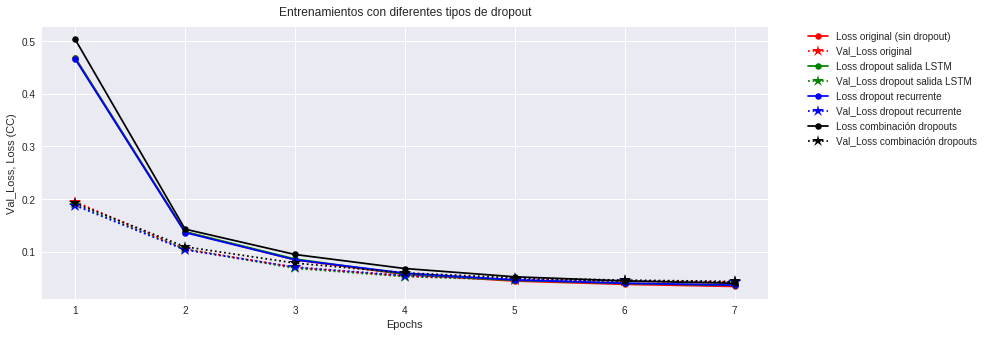

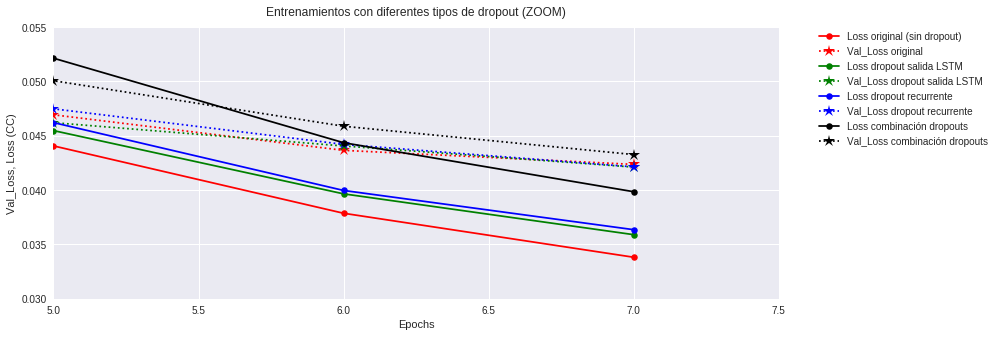

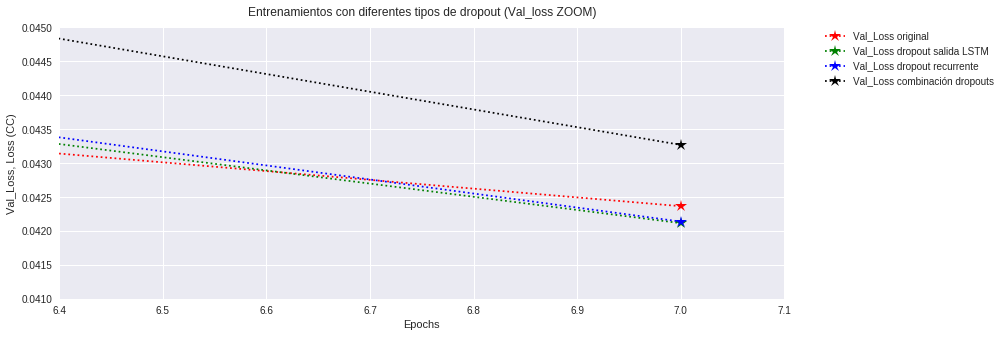

In [0]:
nloss=['Loss original (sin dropout)','Loss dropout salida LSTM','Loss dropout recurrente','Loss combinación dropouts']
nvalloss=['Val_Loss original','Val_Loss dropout salida LSTM','Val_Loss dropout recurrente','Val_Loss combinación dropouts']
colp=['r*:','g*:','b*:','k*:']
cols=['r.-','g.-','b.-','k.-']
a=np.linspace(1,7,7)
plt.title('Entrenamientos con diferentes tipos de dropout',y=1.02)
for i in range(4):
  plt.plot(a,k2l[i],cols[i],label=nloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,k2v[i],colp[i],label=nvalloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

plt.title('Entrenamientos con diferentes tipos de dropout (ZOOM)',y=1.02)
for i in range(4):
  plt.plot(a,k2l[i],cols[i],label=nloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,k2v[i],colp[i],label=nvalloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([5,7.5])
plt.ylim([0.03,0.055])
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

plt.title('Entrenamientos con diferentes tipos de dropout (Val_loss ZOOM)',y=1.02)
for i in range(4):
  plt.plot(a,k2v[i],colp[i],label=nvalloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([6.4,7.1])
plt.ylim([0.041,0.045])
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

*Comentario: Se aprecia un resultado similar al utilizar tan solo dropout en la salida de la capa LSTM o bien tan solo dropout recurrente, a la vez se mejora el resultado original (sin dropout), sin embargo, utilizar una combinación de ambos dropouts resulta ineficiente, empeorando el error de validación. En tanto el loss de entrenamiento empeora a medida que se ocupan dropouts, obteniéndose el menor valor en ausencia de dropouts (original).*

Se realiza la evaluación del modelo mediante f1_score a continuación.

In [0]:
for x in [[0,'sin dropout'],[1,'dropout salida LSTM'],[2,'dropout recurremte'],[3,'combinación de dropouts']]:
  print('Desempeño de la red ',str(x[1]),': ',scores2[x[0]])

Desempeño de la red  sin dropout :  0.9877595909022829
Desempeño de la red  dropout salida LSTM :  0.987508825983696
Desempeño de la red  dropout recurremte :  0.9877767079615722
Desempeño de la red  combinación de dropouts :  0.9874574748058284


*Comentario: Se aprecia que se obtienen valores áltamente semejantes, siendo ligeramente superior el resultado obtenido al utilizar dropout recurrente.*

> **i)** Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Se procede a modificar la red definida en f) utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de lemas de entrada. 

Se procede a experimentar con la diferentes opciones de merge_mode que ofrece keras para programar el comportamiento bidireccional. Keras presenta cuatro posibilidades, las cuales definen cómo las salidas hacia 'delante' y hacia 'atras' (respecto al tiempo) debiesen ser combinadas antes de pasar a la capa siguiente, las opciones son: <br>  
> ‘concat‘:Las salidas se concatenan (default),  este modo genera el doble de outputs para la capa siguiente .<br>‘sum‘: Las dos salidas son sumadas. <br>‘mul‘: Las dos salidas se multiplican<br>‘ave‘: Se calcula el promedio entre las dos salidas.

In [0]:
from keras.layers import Bidirectional
k3l=[]
k3v=[]
scores3=[]
max_input_lenght=81
for i in ['concat','sum','mul','ave']:
  hist=History()
  model = Sequential()
  model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
  layer_lstm = LSTM(units=100,return_sequences=True)
  model.add(Bidirectional(layer_lstm,merge_mode=str(i)))
  model.add(Dense(n_labels, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, epochs=7, batch_size=128,callbacks=[hist])
  k3l.append(hist.history['loss'])
  k3v.append(hist.history['val_loss'])
  a=model.predict(X_test)
  b=f1_score(np.argmax(a,axis=2).reshape(14425*81),np.argmax(y_test,axis=2).reshape(14425*81),average='micro')
  scores3.append(b)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 81, 64)            1295616   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 81, 200)           132000    
_________________________________________________________________
dense_18 (Dense)             (None, 81, 18)            3618      
Total params: 1,431,234
Trainable params: 1,431,234
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/7
33656/33656 [==============================] - 129s 4ms/step - loss: 0.3724 - val_loss: 0.1544
Epoch 2/7
33656/33656 [==============================] - 125s 4ms/step - loss: 0.1071 - val_loss: 0.0771
Epoch 3/7
33656/33656 [==============================] - 125s 4ms/step - loss: 0.0575 - val_loss: 0.0501
Epoch 4/7
33656/33656 [========

Se proceden a graficar los resultados obtenidos

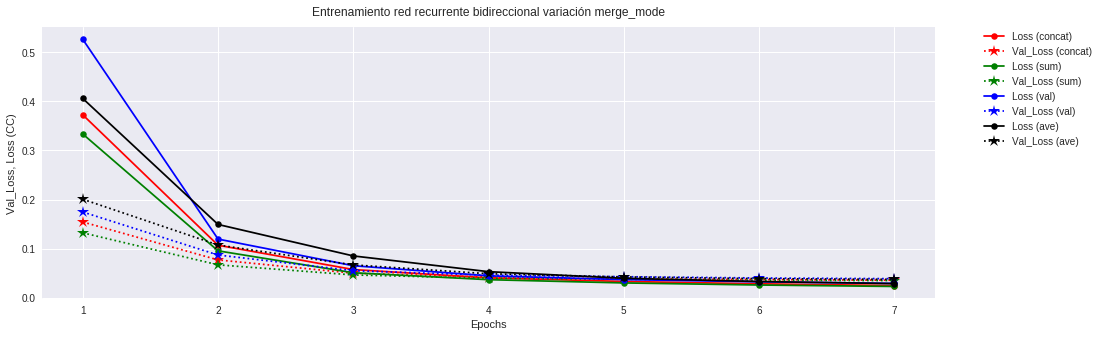

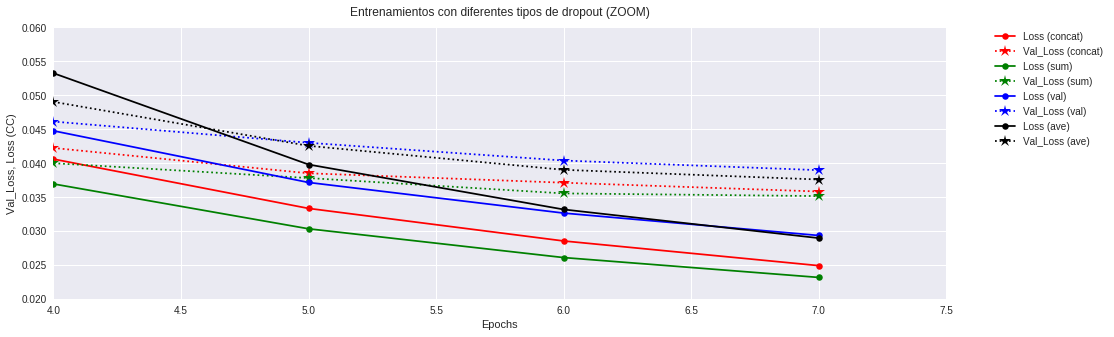

In [0]:
plt.title('Entrenamiento red recurrente bidireccional variación merge_mode',y=1.02)
nloss=['Loss (concat)','Loss (sum)','Loss (mul)','Loss (ave)']
nvalloss=['Val_Loss (concat)','Val_Loss (sum)','Val_Loss (mul)','Val_Loss (ave)']
colp=['r*:','g*:','b*:','k*:']
cols=['r.-','g.-','b.-','k.-']
a=np.linspace(1,7,7)
for i in range(4):
  plt.plot(a,k3l[i],cols[i],label=nloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,k3v[i],colp[i],label=nvalloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

plt.title('Entrenamientos con diferentes tipos de dropout (ZOOM)',y=1.02)
for i in range(4):
  plt.plot(a,k3l[i],cols[i],label=nloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,k3v[i],colp[i],label=nvalloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([4,7.5])
plt.ylim([0.02,0.06])
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

*Comentario: Por medio de la experimentación se determina que se obtiene un mejor desempeño de la red al sumar las salidas bidireccionales. Bien resulta intuitivo que usar la concatenación ayudaría de mejor forma a la red a distinguir cuál salida viene del pasado y cuál del futuro, sin embargo conlleva el aumento de la dimensionalidad de entrada a la capa recurrente bidireccional lo cual puede resultar contraproducente. Se aprecia que el segundo mejor error de validación lo obtuvo la opción de concatenación, posiblemente podría superar a la opción de suma al variar la cantidad de unidades de la capa recurrente, lo cual resulta lógico al tratarse de una mayor dimensión de entrada.*

Se procede a calcular los desempeños de la red mediante f1_score a continuación

In [0]:
for x in [[0,'concat'],[1,'sum'],[2,'mul'],[3,'ave']]:
  print('Desempeño de la red recurente merge_mode',str(x[1]),': ',scores3[x[0]])

Desempeño de la red recurente merge_mode concat :  0.9898530072533539
Desempeño de la red recurente merge_mode sum :  0.9900549885529666
Desempeño de la red recurente merge_mode mul :  0.9889346770224875
Desempeño de la red recurente merge_mode ave :  0.9894019727410831


*Comentario: Se mantiene la jerarquía planteada por el error de validación, siendo superior la opción de suma, a la vez se obtiene el mejor score hasta el momento ¡0.99!*

> j) Recientemente se ha implementado la capa de Masking en las redes recurrentes en keras, lo cual podría traer gran ayuda gracias al padding que se realiza con el símbolo especial definido. Se entrena la red definida en f) y se compara el utilizar esta funcionalidad de enmascarar el valor 0 en este caso para el default de la capa embedding.

Se comprueba que el caracter especial insertado ha sido enumerado como cero

In [0]:
lemma2idx[' !!']

0

Se procede a entrenar a la red con masking a continuación

In [0]:
scores4=[]
embedding_vector = 64
model = Sequential()
hist1=History()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81,mask_zero=True))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, epochs=7, batch_size=128,callbacks=[hist1])
a=model.predict(X_test)
b=f1_score(np.argmax(a,axis=2).reshape(14425*81),np.argmax(y_test,axis=2).reshape(14425*81),average='micro')
scores4.append(b)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 81, 64)            1295616   
_________________________________________________________________
lstm_9 (LSTM)                (None, 81, 100)           66000     
_________________________________________________________________
dense_22 (Dense)             (None, 81, 18)            1818      
Total params: 1,363,434
Trainable params: 1,363,434
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/7
33656/33656 [==============================] - 93s 3ms/step - loss: 0.7946 - val_loss: 0.4114
Epoch 2/7
33656/33656 [==============================] - 90s 3ms/step - loss: 0.3512 - val_loss: 0.2936
Epoch 3/7
33656/33656 [==============================] - 89s 3ms/step - loss: 0.2290 - val_loss: 0.2000
Epoch 4/7
33656/33656 [===========

*Comentario: Mientras la red ocupada en el punto f) tardaba 68 segundos en realizar un epoch posterior al inicial, esta red tarda 21 segundos más en realizar cada epoch posterior al primero, con excepción del segundo que tarda un segundo más.*

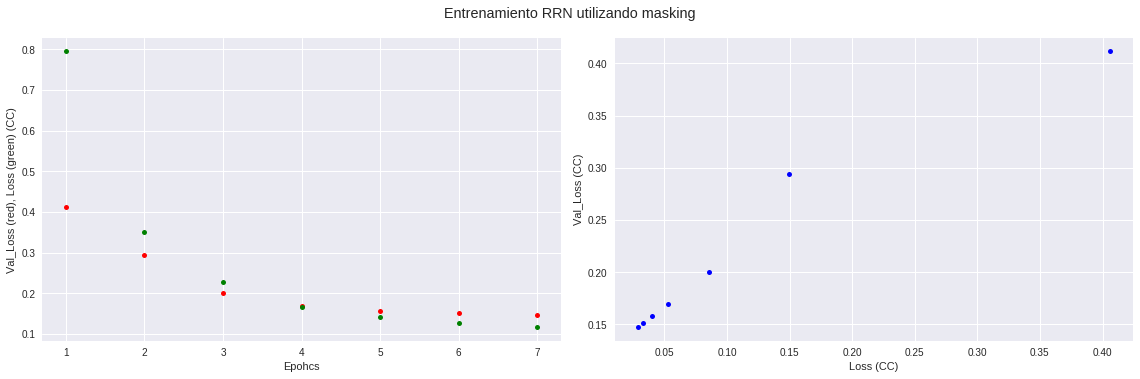

In [0]:
a=np.linspace(1,7,7)
plt.subplot(1,2,1)
plt.suptitle('Entrenamiento RRN utilizando masking',y=1.05)
plt.plot(a,hist1.history['val_loss'],'r.',markersize=10)
plt.plot(a,hist1.history['loss'],'g.',markersize=10)
plt.xlabel('Epohcs')
plt.ylabel('Val_Loss (red), Loss (green) (CC)')
plt.subplot(1,2,2)
plt.plot(hist.history['loss'],hist1.history['val_loss'],'b.',markersize=10)
plt.xlabel('Loss (CC)')
plt.ylabel('Val_Loss (CC)')
plt.tight_layout()
plt.show()

*Comentario: Se observa que el uso del masking resulta en errores de validación bastante peores que la red planteada en f). Por lo que se desestima el uso de este.*

Se calcula el score a continuación

In [0]:
print('Score obtenido usando masking:',scores4[0])

Score obtenido usando masking: 0.25807475875644564


*Comentario: El score obtenido es áltamente deficiente comparado con el obtenido sin ocupar masking.*

> **k)** En base a lo experimentado, se procede a intentar mejorar el desempeño de las redes encontradas

Utilizando la mejor red encontrada hasta el momento (bidireccional, merge_mode:'sum') se intenta mejorar su desempeño al añadir una segunda capa oculta LSTM, modificar el número de unidades ocultas, utilizar dropout recurrente en la primera capa LSTM y aumentar tanto el número de epochs utilizados como el tamaño del embedding. Ésto en base a la experiencia obtenido en ítems previos.

In [0]:
from keras.layers import CuDNNGRU,GRU,Dropout,Embedding, Dense, Bidirectional, LSTM
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.callbacks import History
embedding_vector=96
scores5=[]
hist3=History()
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=81))
layer_lstm = LSTM(units=80,return_sequences=True,recurrent_dropout=0.2)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
layer_lstm = LSTM(units=60,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, epochs=10, batch_size=128,callbacks=[hist3])
a=model.predict(X_test)
b=f1_score(np.argmax(a,axis=2).reshape(14425*81),np.argmax(y_test,axis=2).reshape(14425*81),average='micro')
scores5.append(b)

Train on 33656 samples, validate on 14425 samples
Epoch 1/10
33656/33656 [==============================] - 251s 7ms/step - loss: 0.3076 - val_loss: 0.1430
Epoch 2/10
33656/33656 [==============================] - 248s 7ms/step - loss: 0.0971 - val_loss: 0.0702
Epoch 3/10
33656/33656 [==============================] - 247s 7ms/step - loss: 0.0507 - val_loss: 0.0444
Epoch 4/10
33656/33656 [==============================] - 248s 7ms/step - loss: 0.0352 - val_loss: 0.0381
Epoch 5/10
33656/33656 [==============================] - 248s 7ms/step - loss: 0.0289 - val_loss: 0.0363
Epoch 6/10
33656/33656 [==============================] - 248s 7ms/step - loss: 0.0252 - val_loss: 0.0362
Epoch 7/10
33656/33656 [==============================] - 248s 7ms/step - loss: 0.0224 - val_loss: 0.0348
Epoch 8/10
33656/33656 [==============================] - 247s 7ms/step - loss: 0.0202 - val_loss: 0.0352
Epoch 9/10
33656/33656 [==============================] - 247s 7ms/step - loss: 0.0181 - val_loss: 0.0

A continuación se grafica los errores de entrenamiento y validación para esta red a lo largo de los epochs

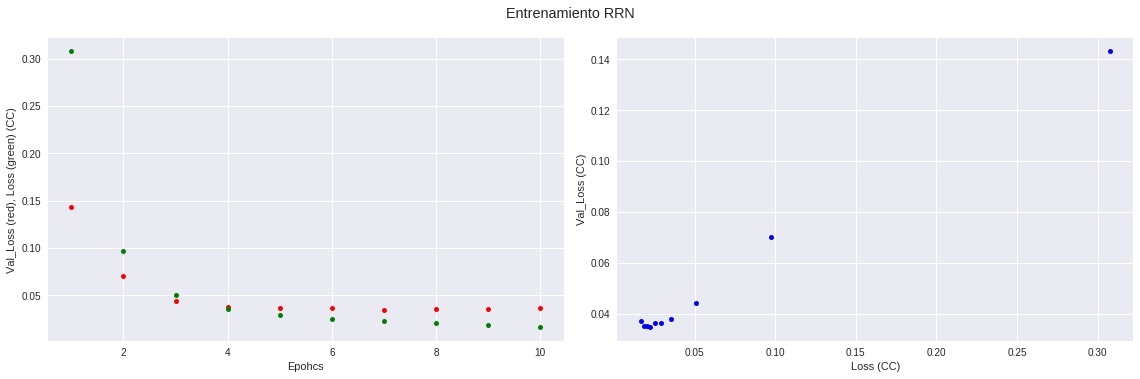

In [0]:
a=np.linspace(1,10,10)
plt.subplot(1,2,1)
plt.suptitle('Entrenamiento RRN',y=1.05)
plt.plot(a,hist3.history['val_loss'],'r.',markersize=10)
plt.plot(a,hist3.history['loss'],'g.',markersize=10)
plt.xlabel('Epohcs')
plt.ylabel('Val_Loss (red), Loss (green) (CC)')
plt.subplot(1,2,2)
plt.plot(hist3.history['loss'],hist3.history['val_loss'],'b.',markersize=10)
plt.xlabel('Loss (CC)')
plt.ylabel('Val_Loss (CC)')
plt.tight_layout()
plt.show()

*Comentario: Se aprecia que se reduce el error de validación mínimo obtenido previamente (0.0351) a 0.0348.*

Luego el score obtenido se muestra a continuación

In [0]:
print('Score obtenido:',scores5[0])

Score obtenido: 0.9906429595395511


In [2]:
dif=0.9906429595395511-0.9900549885529666
print('Se ha aumentado el score obtenido en:',dif)

Se ha aumentado el score obtenido en: 0.000587970986584474


*Comentario: Lográndose un desempeño levemente superior. Resulta difícil mejorarlo aún más dado que el score obtenido es de muy buena calidad, ¡0.01 puntos menor que 1!.*

> **l)** Se muestran las predicciones, el NER tager, sobre algún ejemplo de pruebas, de la red entrenada anteriormente.

In [0]:
p = model.predict(np.array([X_test[20]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[20],p[0]):
    print("{:15}: {}".format(lemmas[w],labels[pred]))

Lemma          : Pred
mr.            : B-per
koizumi        : I-per
's             : O
trip           : O
to             : O
the            : O
middl          : B-geo
east           : I-geo
was            : O
the            : O
first          : O
by             : O
a              : O
japanes        : B-gpe
leader         : O
in             : O
a              : O
decad          : O
.              : O
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!      

A modo de comparar la predicción realizada se visualiza la salida del conjunto de test para esta sentencia a continuación

In [67]:
for w,pred in zip(np.array(X_test[20]),np.argmax(y_test[20],axis=-1)):
    print("{:15}: {}".format(lemmas[w],labels[pred]))

mr.            : B-per
koizumi        : I-per
's             : O
trip           : O
to             : O
the            : O
middl          : B-geo
east           : I-geo
was            : O
the            : O
first          : O
by             : O
a              : O
japanes        : B-gpe
leader         : O
in             : O
a              : O
decad          : O
.              : O
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!            :  !!
 !!       

*Comentario: Se aprecia que la red predice de forma correcta la salida en este caso, asignándose los tags de modo adecaduo a cada lema y al padding realizado.*

#### Aplicación RNNs para autocompletar textos

Se utiliza el mismo dataset para realizar una aplicación más conocida hoy en día que es el autocompletar texto, esto es, predecir la siguiente palabra de una sentencia basada en las palabras anteriores de la misma, por lo que la red que se utilizará es del tipo many to one.
Debido a lo extenso del vocabulario es bastante complejo hacer un modelo que prediga una palabra dentro de las millones que pueden haber, por lo que, trabajaremos a nivel de carácter, en donde las posibilidades (posibles clases) son mucho menores.

> **m)** Se cargan las palabras del dataset y se crea el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). Se utiliza un tamaño del corpus que acomode a la memoria del computador

*Comentario: Se utilizan las palabras en lugar de lemas dado que se busca completar texto, por medio de los lemas no es posible armar oraciones de forma correcta, si no que se generaría un texto más 'cavernicola'.*

In [92]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 20 # cut the text in semi-redundant sequences of maxlen characters
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

total chars: 72
nb sequences: 242697


*Comentario: Se han generado 242693 sentencias, las cuales se componen de 72 characters o menos, dado que se ha utilizado tan solamente un 20% del corpus*

Se ha llevado el dataset a un texto, el cual une todas las sentencias utilizadas en la sección anterior como se ve a continuación (se usan solo letras minúsculas dado que utilizar mayúsculas aumentaría el número de characters innecesariamente)

In [93]:
text[0:100]

'thousands of demonstrators have marched through london to protest the war in iraq and demand the wit'

Luego se divide el texto segun el paso electo de 5, es decir se forman sentencias a partir del quinto character de la sentencia anterior

In [94]:
for i in range(5):
  print(sentences[i])

*thousands of demonst
*ands of demonstrator
*of demonstrators hav
*monstrators have mar
*rators have marched 


Luego se alimentará a la red con los characters que siguen a cada sentencia , los cales se muestran a continuación.

In [95]:
for i in range(5):
  print(next_chars[i])

r
s
e
c
t


> **n)** Se procesan las sentencias para así tenerlas codificadas en números que van a representar los carácteres, tal cual se realizó en c) con los lemmas, lo mismo para las etiquetas. Además de esto se realiza el padding correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase más corta de lo entrenado, este símbolo significará que no hay información. Transforme las etiquetas a one hot vector como se realizó en c) y defina la red similar a la presentada en f), con un embedding seguido de una capa recurrente GRU y la capa de clasificación.

Se procede a transformar las sentencias y próximos carácteres a números

In [0]:
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]

Ahora es necesario hacer padding a las sentencias de modo que la red pueda ser funcional cuando se alimente a esta con sentencias más cortas, para esto es necesario conocer el largo de las sentencias con que se está alimentando a la red.

In [97]:
len(dataX[0])

21

Considerando un largo mínimo de alimentación una sentencia de 2 caracteres se realiza un padding de 38 caracteres mediante el caracter nulo '*'

In [0]:
from keras.preprocessing import sequence
maxlen=maxlen+19
X = sequence.pad_sequences(dataX,maxlen=maxlen,padding='pre',value=char_indices['*'])

Obteniéndose el siguiente resultado

In [99]:
X[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 52, 40, 47, 53, 51, 33, 46, 36, 51,  1, 47, 38,  1, 36, 37,
       45, 47, 46, 51, 52], dtype=int32)

Para la sentencia original

In [100]:
print(dataX[0])

[0, 52, 40, 47, 53, 51, 33, 46, 36, 51, 1, 47, 38, 1, 36, 37, 45, 47, 46, 51, 52]


Por último es necesario convertir los caracteres de salida a un one hot vector que contenga la totalidad de caracteres posibles (72). Adicionalmente se define tanto el conjunto de entrenamiento como de validación.

In [0]:
from keras.utils import to_categorical

y = np.asarray([to_categorical(i, num_classes=len(chars)) for i in dataY])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

Resultando el siguiente data set 

In [102]:
print('Dimensión de entrada dataset : ',X.shape,'\nDimensión de salida dataset : ',y.shape,)
print('Dimensión de entrada dataset de entrenamiento : ',X_train.shape,'\nDimensión de salida dataset de entrenamiento: ',y_train.shape,)
print('Dimensión de entrada dataset de pruebas : ',X_test.shape,'\nDimensión de salida dataset de pruebas : ',y_test.shape,)

Dimensión de entrada dataset :  (242697, 39) 
Dimensión de salida dataset :  (242697, 72)
Dimensión de entrada dataset de entrenamiento :  (169887, 39) 
Dimensión de salida dataset de entrenamiento:  (169887, 72)
Dimensión de entrada dataset de pruebas :  (72810, 39) 
Dimensión de salida dataset de pruebas :  (72810, 72)


Se procede a crear el modelo a utilizar de red recurrente, el cual consitirá de un embedding, una capa GRU (implementación rápida respaldada por CuDNN), seguido por un dropout y una capa dense.

In [103]:
from keras.layers import CuDNNGRU,GRU,Dropout,Embedding, Dense
from keras.models import Sequential
from keras.callbacks import History
embedding_vector = 57
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen))
model.add(CuDNNGRU(units=1024,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 39, 57)            4104      
_________________________________________________________________
cu_dnngru_12 (CuDNNGRU)      (None, 1024)              3326976   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 72)                73800     
Total params: 3,404,880
Trainable params: 3,404,880
Non-trainable params: 0
_________________________________________________________________


> **o)** Se entrena la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada epoch, generando una sentencia completa de 400 carácteres aleatoriamente a partir de una semilla random.

Se procede a crear las funciones que serán incluidas en el callback de entrenamiento de la red con ciertas modificaciones leves para una mejor lectura del texto generado por la red.

In [0]:
def predict_next_char(model, sentence):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds) #take a sample
    return indices_char[next_index]
import random,sys
def on_epoch_end(epoch, logs):
    """Function invoked at end of each epoch. Prints generated text."""
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"\n')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
        if i in [60,160,260,360,399]:
          print('\n')
    return
from keras.callbacks import LambdaCallback

In [105]:
embedding_vector = 57
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen))
model.add(CuDNNGRU(units=1024,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y,batch_size=256,epochs=25, callbacks=[print_callback])

Epoch 1/25
242697/242697 [==============================] - 118s 487us/step - loss: 2.4235 - acc: 0.3029

----- Generating text after Epoch: 0
----- Generating with seed: "e , mr. chavez said the defeat was only"

e , mr. chavez said the defeat was only andial . sapono is arclust futh ofed co the twe sunday and t

hey ino2 , itaq wilating it veleove the focl mromets has bleane sug ibald . thal solmathe. doandat l

unctial aldssion offes aerogly in officises fai heres overs desed statks of fore in ofted covsint an

d herous lelimen of arrenty andegs in the ceaqialy bugan ariand action propes an monduntin stasloch 

of that s exfonting bhecan- oxt artare-

Epoch 2/25
242697/242697 [==============================] - 117s 483us/step - loss: 1.8013 - acc: 0.4685

----- Generating text after Epoch: 1
----- Generating with seed: "gent control , hold those areas securel"

gent control , hold those areas securely provisuenses in the areast in the winrensians would deituri

ze has inceunity for 

*Comentario: Se aprecia que la red logra hilar progesivamente mejor las letras de modo de formar palabras, se logra un accuracy de 0.8236 como máximo en el último epoch. Bien la red a medida que va prediciendo el texto suele perderse aún generando palabras no existentes.*<br>*Esta red fue entrenada con textos acerca de conflictos internacionales por lo cual tenderá a generar textos asociados a esta temática tan solamente.*

p) Se verifica la calidad de la red entrenada, entregando una predicción sobre una semilla inicial entregada.

A continuación se entregan variadas semillas de modo de visualizar la predicción realizada por la red

In [108]:
sentence = "soldiers in "
sentence1 = "soldiers in "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()
    if i in [100-len(sentence1),200-len(sentence1),300-len(sentence1),400-len(sentence1)]:
          print('\n')

----- Generating with seed: "soldiers in "
soldiers in darfur  'stories , and sector , coort authorities after the junict rusing practers from t

he eurapean countries to colleged attack . al-qaida in vance of the imfortant to the siste in the an

ta-a location of family remains vereimly and controversial plans . the expects on new gazes continue

 to demonor to close both made commosting the accident at his plane . seven soldier was buin denied 

the broadca

*Comentario: Se aprecia que la red presenta ciertas incoherencias y palabras inventadas, sin embargo aún así es capaz de generar palabras de forma en geneeral correcta.*

In [111]:
sentence = "they fired against "
sentence1 ="they fired against "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()
    if i in [100-len(sentence1),200-len(sentence1),300-len(sentence1),400-len(sentence1)]:
          print('\n')

----- Generating with seed: "they fired against "
they fired against the central americans . the move failed to approve ateally stricted by a bomb that

 woll resulfers , and being in indua to ts taking for by priforia 's investigation whether a compon 

in pashia , and authorities to intersents to the area . public devemon end which in the eastern kill

ed for more than 10 teossing that providen in somalia and western davasea , where the shorth of bath

ian of 2.5 . the r

*Comentario: Se resalta el hecho de que la red sea capaz de utilizar numeración de forma semi-correcta con esta semilla, haciendo referencia a la sección del texto 'more than 10' y 'of 2.5', pese a que no presente un contexto claro el texto generado*

Durante la experimentación se aprecia que la red opera de manera estocástica y determinista, se entrega a la red tres veces la misma frase a continuación.

In [204]:
sentence = "israel "
sentence1 = sentence
sentence2=''
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()
    if i in [100-len(sentence1),200-len(sentence1),300-len(sentence1),400-len(sentence1)]:
          print('\n')
    sentence2=sentence2+next_char

----- Generating with seed: "israel "
israel . a government with gurrent provide . but he colleged at the positive account to instead after

 and conference thy economy and fire " bon raid day loun , about president for east and the brother 

the world scid he parded the dolivary active ( rabil 2008 . the american terrorist monday and fire a

gainster for the birts . at lease since in north korea 's body report to the peace and are belans to

 she t

Se obtiene el caracter de mayor valor de esta predicción

In [205]:
bb=0
for k in sentence2:
  b=char_indices[k]
  if int(b)>int(bb):
    bb=b
    kk=k
print(kk)

y


In [200]:
sentence = "israel "
sentence1 = sentence
sentence2=''
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()
    if i in [100-len(sentence1),200-len(sentence1),300-len(sentence1),400-len(sentence1)]:
          print('\n')
    sentence2=sentence2+next_char

----- Generating with seed: "israel "
israel . a second to go on decision , saying that news . country and common after that he close other

 in the new only after this eventually among trade . mr. abusin germany says the government has been

 claims that civel of the ordered . he police has discupse , said the government active . mr. grave 

hip evecutions to help but in afghani arrived that his confirmer was the western to with a terroring

 alleg

Se obtiene el caracter de mayor valor de esta predicción

In [201]:
bb=0
for k in sentence2:
  b=char_indices[k]
  if int(b)>int(bb):
    bb=b
    kk=k
print(kk)

y


In [202]:
sentence = "israel "
sentence1 = sentence
sentence2=''
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()
    if i in [100-len(sentence1),200-len(sentence1),300-len(sentence1),400-len(sentence1)]:
          print('\n')
    sentence2=sentence2+next_char

----- Generating with seed: "israel "
israel . air stretter and financial based in iraqi wolls to be delivery . a state of marced at missio

n develop abter in the central furling committee stite pardiament and wing the island to the agreeme

nt and union how recovered on spanior of supar china in recent violence . also this were in the indi

scome at the omposed was at financial confince . in the aim to former to get as a wor iither started

 that 

Se obtiene el caracter de mayor valor de esta predicción

In [203]:
bb=0
for k in sentence2:
  b=char_indices[k]
  if int(b)>int(bb):
    bb=b
    kk=k
print(kk)

y


*Comentario: Es posible ver que luego de recibir los carácteres que forman 'israel ' la red tres veces determinó que continuaba '.', ' ' y 'a' lo que se podría determinar un proceso determinista, luego de estas predicciones de carácteres coherentes en los tres casos se toman decisiones distintas para seguir completando el texto lo cual podría catalogarse de proceso estocástico. A la vez se resalta que en los tres textos se logra el mismo caracter de mayor valor 'y' en el texto generado, sin embargo no se da mayor importancia a esto porque no se aprecia una convergencia del texto, en ninguno de los tres casos mostrados ni previos, posiblemente debido a que la red no se comporta del mismo modo ni siquiera para una misma semilla.*